In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import h5py

In [2]:
import string_constants as sc
import reading_util as ru
import writing_util as wu
import dataset_util as du
import parameter as pa
import quantile_regression_dnn as qr
import data_sample as ds
import plotting_util as pu
import plotting_util_analysis as pua
import flat_cut as fc
import selector as sr
import booster as bo

Using TensorFlow backend.


Welcome to JupyROOT 6.12/07


In [3]:
def make_run_path( strategy, quantile, discriminator ):
    return os.path.join( strategy.path_str,  quantile.path_str, discriminator.path_str )

def make_run_title( strategy, quantile, cut_model ):
    return strategy.title_str + ' ' + quantile.title_str + ' ' + discriminator.title_str

# runtime parameters

In [4]:
# share of total qcd signal region data for QR training (rest for GOF test)
QR_train_share = 0.25 #0.2
# constant fraction wrt dijet mass of BG accepted
quantile = pa.quantile_dict['q1'] # q1 = 1%
# strategy for combining loss-jet-1 and loss-jet-2
strategy = pa.loss_strategy_dict['s5'] # s5 = L1 & L2
# discriminator accepted - rejected
discriminator = pa.discriminator_dict['qr_full']
# path and title infix for all outputs
pathstr = make_run_path( strategy, quantile, discriminator )
titlestr = make_run_title( strategy, quantile, discriminator )

# read in data (qcd and signal)

In [5]:
SM_sample = 'qcdSigAll'
qcd_path = os.path.join( sc.concat_result_dir, sc.sample_loc[SM_sample] + sc.concat_result_suffix )
qcd_data_total = ru.read_results_to_dataframe( qcd_path )

In [6]:
BSM_sample= 'GtoWW30na'
signal_path = os.path.join( sc.concat_result_dir, sc.sample_loc[BSM_sample] + sc.concat_result_suffix )
signal_sample = ds.read_datasample_from_file( 'GtoWW30na', signal_path )

## split qcd data into train and test set 

In [7]:
qcd_data_train, qcd_data_test = du.split_dataset_train_test( qcd_data_total, QR_train_share )

## make qcd_train and qcd_test data samples

In [8]:
qcd_sample_train = ds.DataSample( SM_sample+'_train', qcd_data_train )
qcd_sample_test = ds.DataSample( SM_sample, qcd_data_test )

# Booster

In [9]:
booster = bo.Booster( quantile, strategy, selector ) # sr.QuantileRegressionOverflowBinSelector
booster.train_selector( qcd_sample_train )

In [10]:
model_path = os.path.join('models',pathstr)
!mkdir -p $model_path
booster.save_selector(model_path+'/model.h5')

# VAE Boost

## get selection for qcd sample

In [10]:
booster.boost_sample( qcd_sample_test )

In [11]:
result_sample_path = os.path.join(sc.vae_boost_dir,'selections',pathstr)
!mkdir -p $result_sample_path
qcd_sample_test.dump(os.path.join(result_sample_path,SM_sample+'_sel.h5'))

In [12]:
result_sample_path

'/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_boost/selections/minl1l2_loss/qu_10pct/flat_cut'

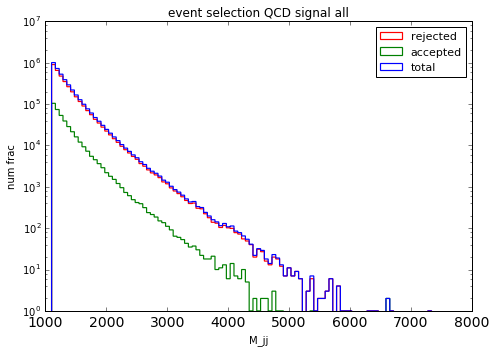

In [13]:
pua.plot_accepted_vs_rejected_hist(qcd_sample_test)

## get selection for signal sample

In [14]:
booster.boost_sample( signal_sample )

In [15]:
signal_sample.dump(os.path.join(result_sample_path,BSM_sample+'_sel.h5'))

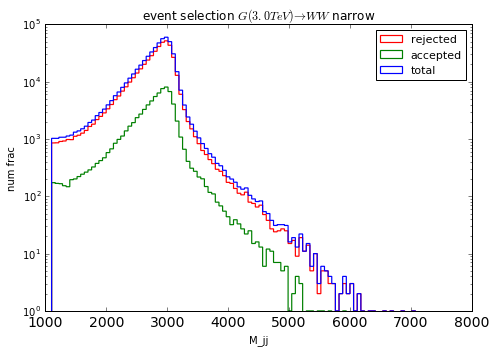

In [16]:
pua.plot_accepted_vs_rejected_hist( signal_sample )

# Binning for bump hunt

In [17]:
bin_edges = [1126,1181,1246,1313,1383,1455,1530,1607,1687,1770,1856,1945,2037,2132,2231,2332,2438,2546,2659,2775,2895,3019,3147,3279,3416,3558,3704,3854,4010,4171,4337,4509,4686,4869,5058,5253,5500,5663,5877,6099,6328,6564,6808]

In [18]:
qcd_tot_cnt, qcd_acc_cnt, qcd_rej_cnt = sr.get_bin_counts_total_acc_rej( qcd_sample_test, bin_edges )

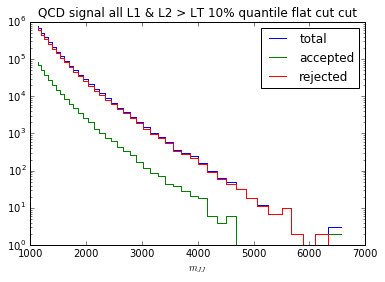

In [19]:
pu.plot_step(bin_edges[:-1],[qcd_tot_cnt, qcd_acc_cnt, qcd_rej_cnt],
             labels=['total','accepted','rejected'],title=qcd_sample_test.title() + ' ' + titlestr,xlabel=r'$m_{JJ}$')

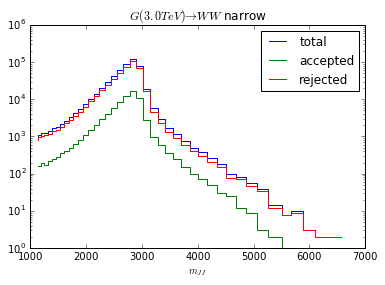

In [20]:
sig_tot_cnt, sig_acc_cnt, sig_rej_cnt = sr.get_bin_counts_total_acc_rej( signal_sample, bin_edges )
pu.plot_step(bin_edges[:-1],[sig_tot_cnt, sig_acc_cnt, sig_rej_cnt],
             labels=['total','accepted','rejected'],title=signal_sample.title(),xlabel=r'$m_{JJ}$')

# write bincounts

In [21]:
bin_count_path = os.path.join(sc.vae_boost_dir,'bin_counts',pathstr)
!mkdir -p $bin_count_path
print(bin_count_path)

/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_boost/bin_counts/minl1l2_loss/qu_10pct/flat_cut


In [22]:
date = datetime.date.today().strftime("%m%d")
bin_file_path = os.path.join( bin_count_path,'bin_counts_'+date+'.h5' )
qcd_counts = np.stack((qcd_tot_cnt,qcd_acc_cnt,qcd_rej_cnt))
sig_counts = np.stack((sig_tot_cnt,sig_acc_cnt,sig_rej_cnt))
wu.write_bin_counts([SM_sample,BSM_sample],[qcd_counts,sig_counts],bin_edges,bin_file_path)

# check dumped data

In [23]:
bin_file_path

'/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_boost/bin_counts/minl1l2_loss/qu_10pct/flat_cut/bin_counts_0511.h5'

[u'GtoWW30na', u'bin_count_labels', u'bin_edges', u'qcdSigAll']


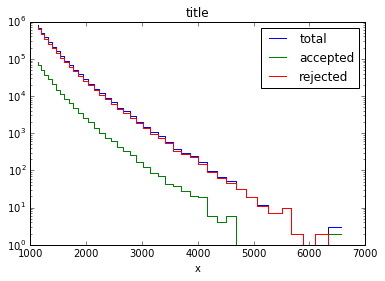

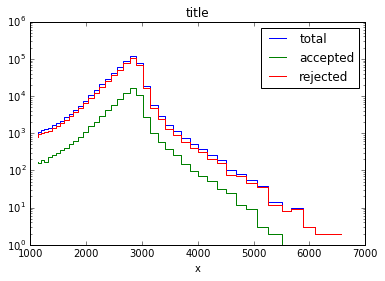

In [24]:
f = h5py.File(bin_file_path,'r')
print(f.keys())
qcd_counts = f.get('qcdSigAll')
sig_counts = f.get('GtoWW30na')
qcd_tot, qcd_acc, qcd_rej = qcd_counts[0], qcd_counts[1], qcd_counts[2]
sig_tot, sig_acc, sig_rej = sig_counts[0], sig_counts[1], sig_counts[2]
pu.plot_step(bin_edges[:-1],[qcd_tot, qcd_acc, qcd_rej],labels=['total','accepted','rejected'])
pu.plot_step(bin_edges[:-1],[sig_tot, sig_acc, sig_rej],labels=['total','accepted','rejected'])
f.close()